## Sentiment Analysis of Amazon Reviews Using Ensemble Method

### Project Overview
In this project, we'll classify the sentiments of Amazon reviews. We'll use NLP preprocessing and TF-IDF to extract features and then create a VotingClassifier ensemble model to determine review sentiment

Our ensemble model will help classify reviews without relying on ratings, providing insight into whether a customer is happy or not



In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords, wordnet as wn
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import string
import seaborn as sns

## Data Cleaning

We'll start with loading our data and checking what it contains

In [2]:
df = pd.read_csv('Reviews.csv')

#checks how many rows vs columns we have
print(f"Our dataset shape- {df.shape}")

#checking if they are all unique
print(f"number of unique items in text column: {df['Text'].nunique()}")

#head() prints the very first 5 rows of each of our columns
#we only really need Score and Text columns
df.head()

Our dataset shape- (568454, 10)
number of unique items in text column: 393579


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Initial Thoughts
- For our analysis, the only columns we really need are Text and Score
- Since our goal is sentiment analysis, information like UserId and ProductId isn't as useful
- While the Summary section *might* be beneficial with some additional weighting methodology, I'll focus on the basics for now

### Addressing data shape vs uniqe number of items in text column

- Our shape is 568,454 rows, and 10 columns
- The number 393579 for unique text items above suggests that we have some duplicates in our text column in csv

Let's do a thorough check and then get rid of duplicates

In [3]:
#create a dataframe containing only the text and score columns
dropped_columns = ['Summary','HelpfulnessNumerator','HelpfulnessDenominator','Id','ProductId','UserId','ProfileName','Time']
#drop all the columns that are not necessary
df = df.drop(dropped_columns, axis =1)


#remove duplicate values from the text column
df = df.drop_duplicates(subset='Text')

#get the number of unique items we have in our text column
num_unique = df['Text'].nunique()

#get the total number of items we have in text column
total_items = len(df['Text'])

#run a quick check for duplicates
if num_unique == total_items:
    print("all items in the text column are unique")
else:
    print("there are duplicates text column")

print(f"Dataset shape- {df.shape}")

#check for empty values within the dataframe
df.isnull().sum()

#check our dataset's score distribution
print(f"Score value count: \n{df['Score'].value_counts()}")

all items in the text column are unique
Dataset shape- (393579, 2)
Score value count: 
Score
5    250716
4     56042
1     36275
3     29754
2     20792
Name: count, dtype: int64


## Distribution of our classification
- Positive: 4 and 5 star reviews
- Neutral: 3 star reviews
- Negative: 1 and 2 star reviews


According to our value counts above - We have far more positive reviews than negative, need to balance our classes to prevent overfitting

Let's run a quick visualization on how the distribution looks like:

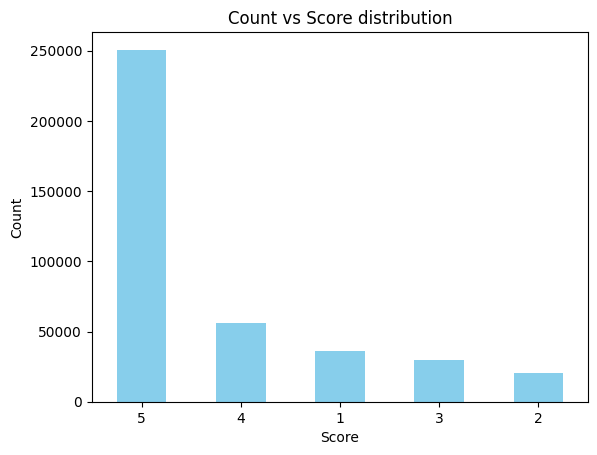

In [4]:
#creating a simple bar graph
df['Score'].value_counts().plot.bar(color='skyblue')
plt.title('Count vs Score distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Method to balance out our dataset

The idea is to end up with equal number of positive and negative reviews, while considering the difference between 1 star reviews and 2 star reviews

- Let's start with calculating the overall number of negative reviews we have

  **number of 1&2 star reviews** = 36,275 + 20792 = **57,067**

- Now let's calculate the amount of positive reviews we have

  **number of 4&5 star reviews** = 250,716 + 56,042 = **306,758**

### To Prevent Overfitting

- We'll balance the number of 4 and 5 star reviews with 1 and 2 star reviews by randomly reducing the 4 and 5 star reviews 
- To do that, we'll ensure there are more 5 star reviews than 4 star reviews by the difference between the number of 1 star and 2 star reviews


  **number of reviews to drop for 5 star** = 250,715 - 36,275 = **214,440 reviews**

  **number of reviews to drop for 4 star** = 56,042 - 20792 = **35,250 reviews**

This way we'll end up with **36,275** reviews for both 1 and 5 star reviews and **20,792** reviews for 2 and 4 star reviews


In [5]:
#get numerical value of each score and store in a list, the order is based on highest to lowest(5, 4, 1, 3, 2)
score_counts = df['Score'].value_counts().tolist()

print(score_counts)

#drop anything that has score 3, I found neutral doesn't tell us much
df = df[df['Score'] != 3]

#these variables will be how much we want to retrain from 5 star and 4 star reviews
one_star_reviews = 36275 
two_star_reviews = 20792
num_to_drop = []

#calculate how much rows we'll need to drop from scores 4 and 5
num_to_drop.append(score_counts[0]-one_star_reviews)
num_to_drop.append(score_counts[1]-two_star_reviews)


#dropping reviews from 5 and 4 star at random(0 to n-1)
for score_to_drop in range(len(num_to_drop)):
    if num_to_drop[score_to_drop] > 0:
        #create new dataframe from random samples for a specific score
        excess_rows = df[df['Score'] == 5-score_to_drop].sample(n=num_to_drop[score_to_drop],random_state=42)
        #drop the new dataframe - .index of a dataframe refers to the rows
        df = df.drop(excess_rows.index)

#print all of our values again
print(f"Score value count: \n{df['Score'].value_counts()}")


[250716, 56042, 36275, 29754, 20792]
Score value count: 
Score
1    36275
5    36275
2    20792
4    20792
Name: count, dtype: int64


Let's see how our methodology affected our dataset

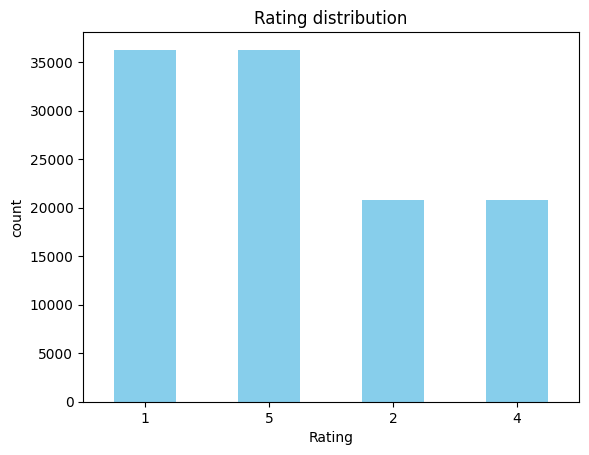

In [6]:
#creating a bar graph once more to visualize what we did
df['Score'].value_counts().plot.bar(color='skyblue')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.show()

# NLP pre-processing

Now that we have cleaned the data and balaanced out our classes, we'll prep our dataset using NLP techniques

- **BeautifulSoup's HTML Parser** - Some of the reviews have HTML syntax, so we'll have to remove it
- **Regex pattern** - Based on specific pattern(see below), remove noise from data
- **stopwords removal** - Taking out words that are not important for sentiment analysis
- **lowercasing** - Standardizes our entire corpus of text to represent all words in the same manner
- **Tokenize** - Isolates our words within a sentence and results in a list of words
- **Lemmatizing** - Standardizes our vocab further to reduce dimensionality

## Parsing HTML from Text Column
To clean our Text column in our dataframe we'll need to first address the HTML tags we have in some of the reviews. To do that, we'll use BeautifulSoup's HTML parser

#### Using Lambda function
`'lambda x'` is a user defined function that takes x as a parameter, and performs an action, in our case `'html.parser'`

- from `df['Text']`, parse through all rows and extracts html
- `.apply()` takes a function as an argument and applies it to each element(cell) in a specific df column
- `.get_text()` removes all html tags, returning cleaned text

In [7]:
#removing HTML tags from our text
df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

#printing our first 5 rows of data
df.head()

/tmp/ipykernel_10000/578222121.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())


,Score,Text
1,1,Product arrived labeled as Jumbo Salted Peanut...
3,2,If you are looking for the secret ingredient i...
9,5,This is a very healthy dog food. Good for thei...
12,1,My cats have been happily eating Felidae Plati...
13,4,good flavor! these came securely packed... the...


## Define and Apply a Regex Pattern

To clean the Text column, we'll use regex to remove unwanted characters. This is how we'll define our pattern:

- 'r' - indicates a literal string
- '^' - negation operator(any char that is NOT within the specified range)
- 'A-Za-z0-9' -  matches the range of chars, uppercase letters, lowercase letters, and numbers
- '\s' - matches any whitespace chars(spaces,tabs, newlines)

The pattern `r'[^A-Za-z0-9\s]'` matches any character that is **not** an uppercase letter, lowercase letter, digit, or whitespace.

In [8]:
#create the pattern
pattern = r'[^A-Za-z0-9\s]'
#remove anything that is NOT within the pattern(hence the '^' for negation)
df['Text'] = df['Text'].apply(lambda x: re.sub(pattern,'',x))

#from string library removes all white spaces trailing or leading to sentence
df['Text'] = df['Text'].apply(lambda x: x.strip())

df.head()

,Score,Text
1,1,Product arrived labeled as Jumbo Salted Peanut...
3,2,If you are looking for the secret ingredient i...
9,5,This is a very healthy dog food Good for their...
12,1,My cats have been happily eating Felidae Plati...
13,4,good flavor these came securely packed they we...


## Lowercasing
- Lowercasing is necessary because uppercase and lowercase letters are not equivalent for computers. While humans see Cat and cat as the same word, a computer treats them as different words. By converting all text to lowercase, we standardize the data, reducing our dimensionality and ensuring consistency within our corpus of text

In [9]:
#any uppercase char converted into lower case
df['Text'] = df['Text'].apply(lambda x: x.lower())

df.head()

,Score,Text
1,1,product arrived labeled as jumbo salted peanut...
3,2,if you are looking for the secret ingredient i...
9,5,this is a very healthy dog food good for their...
12,1,my cats have been happily eating felidae plati...
13,4,good flavor these came securely packed they we...


## Removing more noise such as stopwords
Stopwords are often not as important in determining sentiment since they can appear in both negative and positive reviews. Their removal can reduce our time complexity while not significantly affecting the outcome. Given that we are using the TF-IDF method, which is a Bag of Words methodology, it is generally beneficial to remove stopwords to improve efficiency and focus on more meaningful words.

However, when considering contraction stopwords like "not" or "don't", they could be crucial in understanding the sentiment. For example:

- `"i like this product" vs "i **don't** like this product"`

In this example "don't" is a stopword that changes the entire sentiment of the sentence. Therefore, it is important to retain certain stopwords in our vocabulary collection.

## no_stopwords

To deal with that we'll construct a variable called "no_stopwords" for words in the stopword list that are important for us to retain. This will be used later on after tokenizing.

In [10]:
# Download stopwords and word tokenizer
#nltk.download('stopwords')
#nltk.download('punkt')


#load stopwords and store in a set which is a hashmap that has O(1) find(), this is helpful when it comes to finding whether a word is a stopword or not
nltk_stopwords = set(stopwords.words('english'))

#words that we want to keep
no_stopwords = ["not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
               'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
               "won't", 'wouldn', "wouldn't"]

#for each element in no_stopwords list, we remove these words from the nltk_stopwords list
#what this does is handling contractions as they are quite important for sentiment
for no_stopword in no_stopwords:
    nltk_stopwords.remove(no_stopword)


## Tokenizing

- Tokenizing splits text into individual words or tokens. It is a very important step in text NLP pre-processing(see below). This essentially breaks down sentences/documents into smaller pieces/words for us to continue our pre-processing pipeline.

In [11]:
#tokenize our words
df['Text'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

#printing first few rows to show changes in our Text column
df.head()

,Score,Text
1,1,"[product, arrived, labeled, as, jumbo, salted,..."
3,2,"[if, you, are, looking, for, the, secret, ingr..."
9,5,"[this, is, a, very, healthy, dog, food, good, ..."
12,1,"[my, cats, have, been, happily, eating, felida..."
13,4,"[good, flavor, these, came, securely, packed, ..."


## Stopword removal
Once we tokenize the text, we can parse through each tokenized sentence/document to remove stopwords more efficiently. Using tokenizer is essential for accurate stopword removal, without it, task would be more challenging as sentences are not broken into individual words.

## lambda function
The lambda function used here differs slightly in syntax due to the tokenization of rows in the `'Text'` column:
- x represents each row in our dataframe, where each row contains a list of strings after tokenization(see the printed example above)
- The function iterates over each word (`word`) in the list (`x`) and checks if it is not a stopword (`word not in nltk_stopwords`)
- Words that are not stopwords are appended to a new list, while stopwords are filtered out (skipped) from the new list
- This results in a list without stopwords returned for each row


In [12]:
#removing all the stopwords from our reviews
df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in nltk_stopwords])

#printing first few rows to show changes in our Text column
df.head()

,Score,Text
1,1,"[product, arrived, labeled, jumbo, salted, pea..."
3,2,"[looking, secret, ingredient, robitussin, beli..."
9,5,"[healthy, dog, food, good, digestion, also, go..."
12,1,"[cats, happily, eating, felidae, platinum, two..."
13,4,"[good, flavor, came, securely, packed, fresh, ..."


## Lemmatizing
Lemmatizing is the process of reducing a word to its base form. The purpose of lemmatizing is to further reduce dimensionality, allowing models to analyze and compare text more efficiently

An example of lemmatizing:

- manage &rarr; manage
- manager &rarr; manage
- managing &rarr; manage
- managed &rarr; manage
- manages &rarr; manage

Since words can have different roles in sentences, it is important for us to determine their part of speech tag. After determining their tag, the `nltk` library handles lemmatization accurately based on these tags

### Example:

`swimming` is a good sport **vs** i go `swimming` for fun


**First sentence** - "swimming is a good sport"
- "swimming" is used as the subject of the sentence, like a noun

**Second sentence** - "i go swimming for fun"
- "swimming" is used as a verb for this sentence

In [13]:
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#converting nltk pos to wordnet pos
def wordnet_pos(tag):
    #tag is a string of letters, just need the first one to identify correct tag
    if tag[0] == 'J':
        return wn.ADJ
    elif tag[0] == 'V':
        return wn.VERB
    elif tag[0] == 'N':
        return wn.NOUN
    elif tag[0] == 'R':
        return wn.ADV
    else:
        #default to noun if nothing found
        return wn.NOUN

#this function takes a list of words and lemmatizes it
def lemmatize_words(text):
    #nltk.pos_tag returns a list of ('word', pos_tag)
    pos = nltk.pos_tag(text)
    lemmatized_words = []
    for word, nltk_tag in pos:
        #reason to convert is to ensure compatibility with wordnet's lemmatize pos tag
        wn_pos = wordnet_pos(nltk_tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=wn_pos))
    return lemmatized_words

In [14]:
#lemmatizing our vocab with proper POS tags
df['Text'] = df['Text'].apply(lambda x: lemmatize_words(x))

#printing changes
df.head()

,Score,Text
1,1,"[product, arrive, labeled, jumbo, salt, peanut..."
3,2,"[look, secret, ingredient, robitussin, believe..."
9,5,"[healthy, dog, food, good, digestion, also, go..."
12,1,"[cat, happily, eat, felidae, platinum, two, ye..."
13,4,"[good, flavor, come, securely, pack, fresh, de..."


In [15]:
#creates a list of scores out of Score column
col_score = df['Score'].tolist()

#converting to binary positive and negative classification
score = []
for x in col_score:
    if x>= 4:
        score.append(1)
    else:
        score.append(0)

print(f"our dependent values: {score[:5]}")

our dependent values: [0, 0, 1, 0, 1]


# TF-IDF (Term Frequency-Inverse Document Frequency)

When it comes to sklearn's models, we can only use numerical values for our features. Since we are using words as features, we need a method to convert these words into numerical values that the model can interpret.

TF-IDF is a method used to calculate how relevant a word is to a specific document in the context of the entire corpus of text. It combines two formulas:

## TF (Term Frequency)

TF takes a document or sentence and calculates how often a word appears in the same document or sentence

$$
\text{TF}(t, d) = \frac{\text{number of times } t \text{ appears in document } d}{\text{total number of words in document } d}
$$
## IDF (Inverse Document Frequency)

IDF is an extra method to weigh words in relation to the entire corpus of text we have (all of our reviews)
$$
\text{IDF}(t) = \log(\frac{\text{number of documents containing word } t}{\text{total amount of documents}})
$$

$$\text{TF} * \text{IDF} = \text{numerical value of a word in relation to the entire dataset}$$

After the process is done for the entire corpus of text, we end up with a 2D matrix that assigns different weights to features(words). Common words have lower weights, while important and informative words are highlighted with higher TF-IDF scores.

In [16]:
#load libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

## TF-IDF Vectorization

- **.fit** - Using the formulas above `.fit` method learns the paramters for each word in the training data(features)
- **.transform** - The `.transform` method applies the parameters learned from .fit to our data. For TF-IDF, it returns a 2D matrix of numerically represented words

### Important notes
- It is important to apply .fit **only** on training data. Applying it on test data would result in TF-IDF learning parameters from the test set, leading to biased evaluation
- When a word is present in the test data but not in the training data, it is assigned a value of 0 to handle unseen words. This is known as **OOV**(Out of Vocabulary)
- Test data must be transformed using `.transform` to emulate real world data evaluation, where models encounter unseen reviews for sentiment analysis

### Addressing sparse matrix
Since by default, TF-IDF considers each word a feature, it can create a large 2D matrix at the cost of runtime. To deal with runtime issues, `TfidfVectorizer` has a paramter called `max_features` which takes a number as an argument. Based on the number n, we take the n most important features by frequency and construct our matrix from them. When considering a `max_feature` value, there's a loose rule of thumb of N > P:

- **N** - The number of documents(reviews) in the dataset
- **P** - The number of max feature chosen

This way we can ensure that there are enough documents to cover enough important patterns in the vocabulary

### ngram_range feature
By default, TF-IDF considers each word as a feature(unigrams). Using the ngram_range feature in TfidfVectorizer, we can include multiple words as features (bigrams). This still is used within the limits set by `max_features`.


In [17]:
#create our vectorizer with specified parameters
#min_df = 0.03 -> this means we're ignoring words that appear in less than 1% of the documents
#this is taking care of edge cases where words might not be as significant due to rarity AND prevents potential overfitting
tf_idf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=0.01)

#out of all 'Text' columns, creates a list that contains lists of tokenized words in form of - list of lists of words
col_list = df['Text'].tolist()

#print example of our list of list of words first element
print(col_list[2])

corpus = []
#tf-idf needs a list of documents/sentences - for each list in col_list, we join them with a space in between, then append to new list
for index in col_list:
    corpus.append(' '.join(index))

#print the same example of our changes - list of strings
print(corpus[2])

#perform train test split with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(corpus, score, test_size=0.2, stratify=score,random_state=42)

#learn the parameters of our training data
tf_idf_vectorizer.fit(X_train)

#transform both train and test data(based on X_train parameters)
tfidf_train = tf_idf_vectorizer.transform(X_train)
tfidf_test = tf_idf_vectorizer.transform(X_test)


['healthy', 'dog', 'food', 'good', 'digestion', 'also', 'good', 'small', 'puppy', 'dog', 'eats', 'require', 'amount', 'every', 'feeding']
healthy dog food good digestion also good small puppy dog eats require amount every feeding


## Frequency Visualization
For visual context, let's check our term frequency across our entire corpus. This is very similar to WordCloud

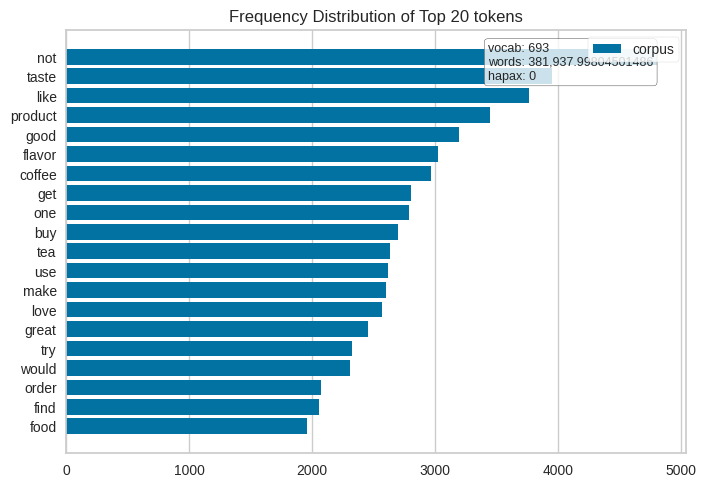

<Axes: title={'center': 'Frequency Distribution of Top 20 tokens'}>

In [18]:
from yellowbrick.text import FreqDistVisualizer

#using TfidfVectorizer method from Sklearn to extract features
features = tf_idf_vectorizer.get_feature_names_out()
#choosing top 20 features
visualizer = FreqDistVisualizer(features=features, n=20)
visualizer.fit(tfidf_train)
visualizer.show()

## Using k-fold cross validation
To ensure no outliers and we are consistent with the model's performance, we can perfom k-fold cross validation

This essentially divides our dataset into k equal parts(stratified), then we get a training set of size k-1 out of the k parts, and the remaining part is for testing.

In case of our 5 fold cross validation:
- model 1: train- 1,2,3,4  test- 5
- model 2: train- 1,2,3,5  test- 4
- etc..

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

#logistic regression model with stochastic gradient descent
logistic_regression_model = LogisticRegression(solver='saga')

print(cross_val_score(logistic_regression_model,tfidf_train,y_train,cv=5))

[0.84771657 0.84656664 0.84727014 0.84918679 0.84497015]


## Model Creation and Evaluation

Now that we know we are consistent with our model creation, let's create a logistic regression model and evaluate it:

### Precision
- Measures how accurate our model is when predicting positive reviews out of *all* reviews it classified as positive(including negative reviews falsely classified as positive):

    $ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $


### Recall (Sensitivity)

- Measures how well our model predicts positive reviews out of *all* the positive reviews present in our dataset

    $ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $


### F1 Score

- Combines both Precision and Recall and checks if they are balanaced. We want a model that has balanced Precision score and Recall score. If one outweighs the other, our F1 score lowers

    $ \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $

In [20]:
#train the model
logistic_regression_model.fit(tfidf_train, y_train)

#predict on test data
y_pred = logistic_regression_model.predict(tfidf_test)


#evaluating our LR model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#print the evaluation
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('F1 Score:', f1)

accuracy: 0.8471546852411618
precision: 0.8471784086926043
recall: 0.8471041794444931
F1 Score: 0.8471412924424971


## Confusion matrix
When evaluating classification models, percentages alone might not provide a full picture of accuracy. A confusion matrix is then used for showing a detailed evaluation of our model's performance. It helps identify areas where the model performs well and where there might be inconsistencies in classification

[[9670 1744]
 [1745 9668]]


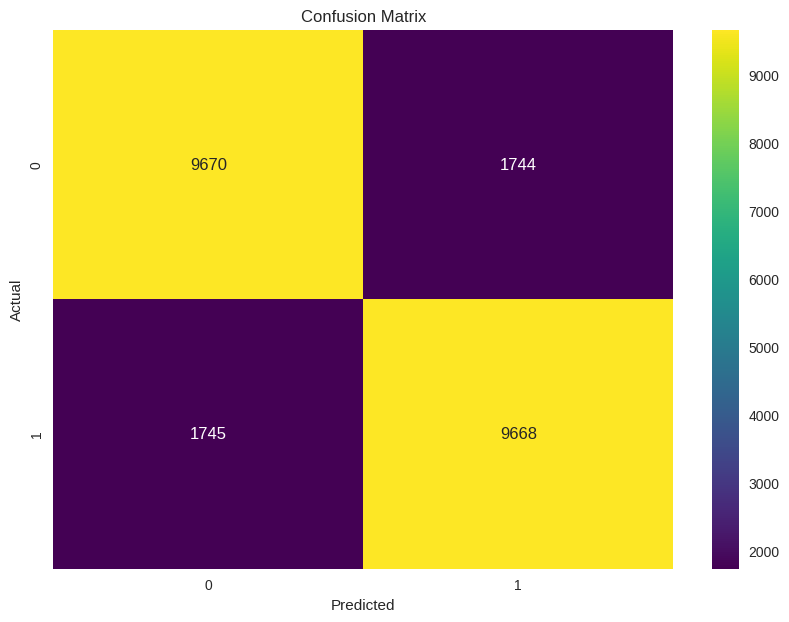

In [21]:
#create confusion matrix from data
cm = confusion_matrix(y_test, y_pred)

print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=logistic_regression_model.classes_, yticklabels=logistic_regression_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Example of misclassified sentence
Let's check an example of misclassified text from our model's prediction


In [22]:
#create our variables to track appropriate misclassifications
index = 0
misclassified_text = []
misclassified_index = []
misclassified_actual_labels = []
misclassified_predicted_labels = []

#zip allows us to iterate over multiple variables:
# label = curr iteration of y_test
# predict = curr iteration of y_pred
for label, predict in zip(y_test, y_pred):
    if label != predict: 
        misclassified_index.append(index)
        misclassified_actual_labels.append(label)
        misclassified_predicted_labels.append(predict)
        #Referenced from - https://stackoverflow.com/questions/31593201/how-are-iloc-and-loc-different/31593712#31593712
        misclassified_text.append(df.iloc[index]['Text'])
    index +=1

#print our results
print("actual label:", misclassified_actual_labels[misclassified_index[8]])
print("predicted label:", misclassified_predicted_labels[misclassified_index[8]])
print("misclassified text:", misclassified_text[misclassified_index[8]])

actual label: 0
predicted label: 1
misclassified text: ['really', 'like', 'chip', 'different', 'texture', 'regular', 'potato', 'chip', 'still', 'find', 'really', 'tasty', 'even', 'boyfriend', 'often', 'averse', 'thing', 'healthy', 'low', 'fat', 'gobble', 'rather', 'quickly', 'variety', 'pack', 'great', 'allow', 'little', 'bit', 'everything', 'course', 'downside', 'may', 'not', 'like', 'flavor', 'much', 'find', 'original', 'version', 'little', 'bland', 'sea', 'salt', 'vinegar', 'flavor', 'might', 'strong', 'people']


## Ensemble method - VotingClassifier
At the cost of training more models(runtime), we can potentially increase our performance by using `VotingClassifier`. This creates an environment in which we have a diverse model combination that is potentially more stable and reliable than a singular model prediction.

In [23]:
from sklearn.ensemble import RandomForestClassifier
#creating a randomforest model
rforest = RandomForestClassifier(random_state=42)

Starting off with random forest classifier, run a grid search to optimize it

In [24]:
# #for grid search
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : [4,5,6,8,10],
#     'criterion' :['gini', 'entropy']
# }

# #perform grid search with 5-fold cross validation
# cv_rforest = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= 5)
# #print the best params for the model
# cv_rforest.best_params_

# #result of grid search is(saving runtime)
# param_grid = { 
#     'n_estimators': [500],
#     'max_features': ['log2'],
#     'max_depth' : [10],
#     'criterion' :['entropy']
# }

Creating ensemble model with voting classifier method from sklearn

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn import svm

#instantiate support vector classifier
svm_clf = svm.SVC()

#instantiate best params fit
best_param_rf = RandomForestClassifier(n_estimators=10, max_features='log2',max_depth=10,criterion='entropy')

#create an ensemble VotingClassifier
ensemble_clf= VotingClassifier(estimators= [('lr',logistic_regression_model),('rf',best_param_rf),('svm',svm_clf)], voting ='hard')

#.fit the training data
ensemble_clf.fit(tfidf_train,y_train)

#predict and print accuracy
ensemble_y_pred = ensemble_clf.predict(tfidf_test)

#evaluating our ensemble model
accuracy = accuracy_score(y_test, ensemble_y_pred)
precision = precision_score(y_test, ensemble_y_pred)
recall = recall_score(y_test, ensemble_y_pred)
f1 = f1_score(y_test, ensemble_y_pred)

#print the evaluation
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('F1 Score:', f1)

accuracy: 0.8543391597669426
precision: 0.8527564549895325
recall: 0.8565670726364671
F1 Score: 0.8546575162827292


Creating a confusion matrix for our ensemble model

[[9726 1688]
 [1637 9776]]


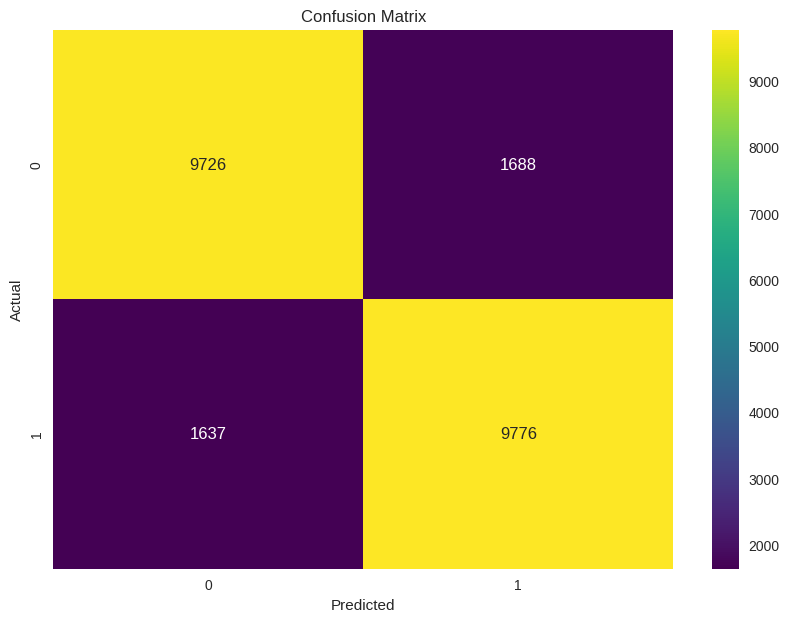

In [26]:
cm = confusion_matrix(y_test, ensemble_y_pred)

print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=ensemble_clf.classes_, yticklabels=ensemble_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()